In [ ]:
!pip install pandas
!pip install networkx
!pip install torch
!pip install scikit-learn

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
!pip install torch-geometric


Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=504020 sha256=2113c018bdb7262a53309b975ecbffcd7dbb6510d0c663f472e27040011efbb9
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1071448 sha256=b2b97fe2c5f3e9dc8a9b49f9625a5a76385b2831bf624535e325b7cdcf75f385
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
Success

In [ ]:
import pandas as pd
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch.optim as optim

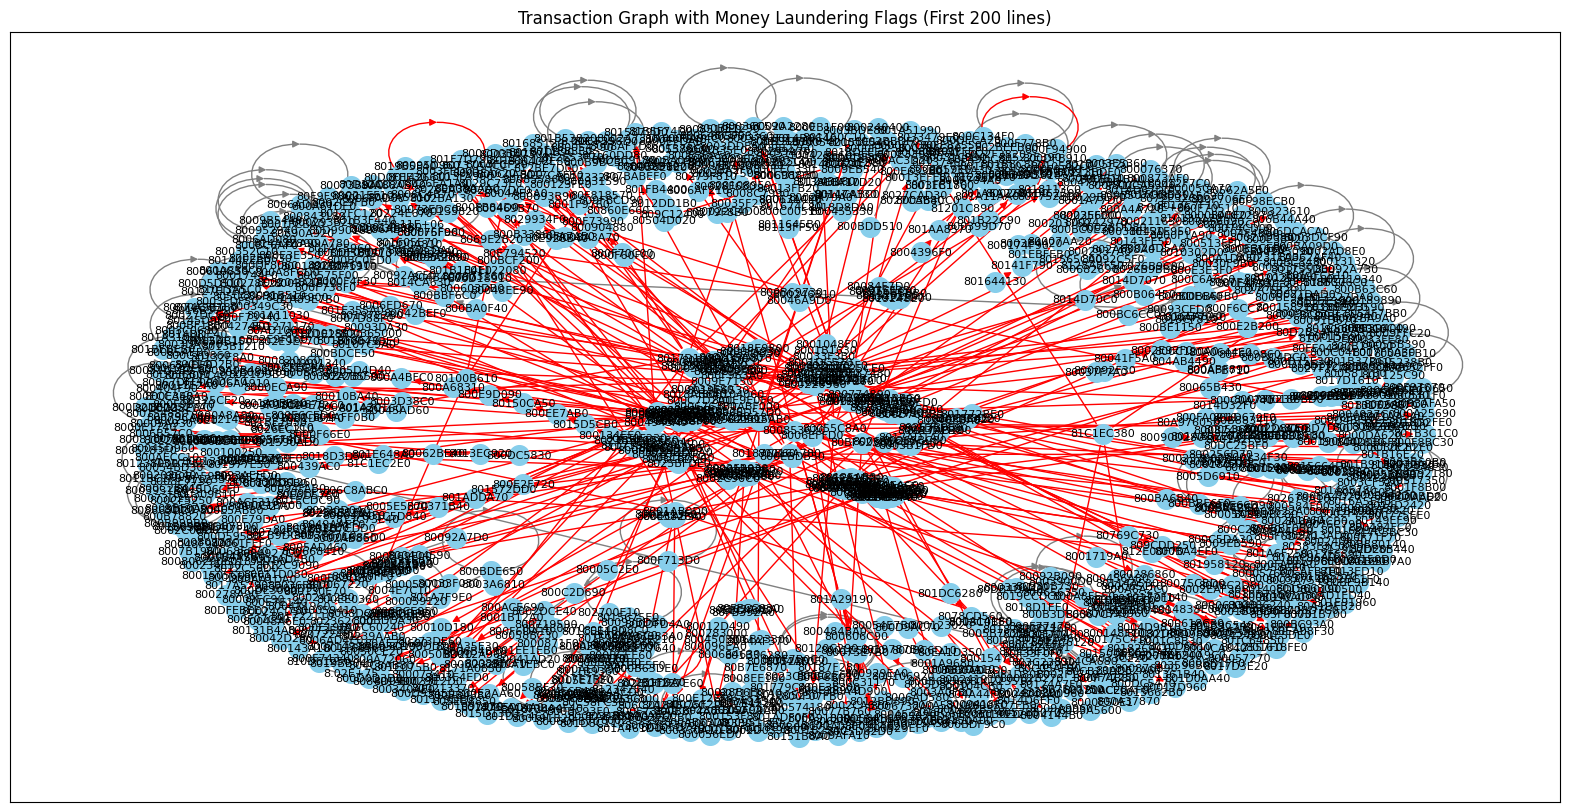

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

data = pd.read_csv("/content/drive/MyDrive/MLGA/raw/LI-Small_Trans.csv")

G = nx.DiGraph()


for i, row in data.head(200).iterrows():
    G.add_edge(row['Account'], row['To Account'], amount=row['Amount Received'])
with open("/content/drive/MyDrive/MLGA/raw/LI-Small_Patterns.txt", "r") as file:
    lines = file.readlines()

    for line in lines:
        if line.startswith("BEGIN LAUNDERING ATTEMPT"):
            laundering_attempt = True
        elif line.startswith("END LAUNDERING ATTEMPT"):
            laundering_attempt = False
        elif laundering_attempt:
            transaction_info = line.split(",")
            if len(transaction_info) == 11:
                from_account = transaction_info[2]
                to_account = transaction_info[4]
                # Add nodes if they don't exist
                if from_account not in G:
                    G.add_node(from_account)
                if to_account not in G:
                    G.add_node(to_account)
                # Add edge with 'color' attribute
                G.add_edge(from_account, to_account, color='red')

# Visualize the graph
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G, seed=42)

# Draw edges
edge_colors = [G[u][v].get('color', 'gray') for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color=edge_colors)

# Draw nodes and labels
nx.draw_networkx_nodes(G, pos, node_size=200, node_color="skyblue")
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Transaction Graph with Money Laundering Flags (First 200 lines)")
plt.show()


In [ ]:
print(data.head())

         Timestamp  From Bank    Account  To Bank To Account  Amount Received  \
0  01/09/2022 0:08         11  8000ECA90       11  8000ECA90       3195403.00   
1  01/09/2022 0:21       3402  80021DAD0     3402  80021DAD0          1858.96   
2  01/09/2022 0:00         11  8000ECA90     1120  8006AA910        592571.00   
3  01/09/2022 0:16       3814  8006AD080     3814  8006AD080            12.32   
4  01/09/2022 0:00         20  8006AD530       20  8006AD530          2941.56   

  Receiving Currency  Amount Paid Payment Currency Payment Format  \
0          US Dollar   3195403.00        US Dollar   Reinvestment   
1          US Dollar      1858.96        US Dollar   Reinvestment   
2          US Dollar    592571.00        US Dollar         Cheque   
3          US Dollar        12.32        US Dollar   Reinvestment   
4          US Dollar      2941.56        US Dollar   Reinvestment   

   Is Laundering  
0              0  
1              0  
2              0  
3              0  
4  

In [ ]:
print(data.dtypes)

Timestamp              object
From Bank               int64
Account                object
To Bank                 int64
To Account             object
Amount Received       float64
Receiving Currency     object
Amount Paid           float64
Payment Currency       object
Payment Format         object
Is Laundering           int64
dtype: object


In [ ]:
print('Amount Received equals to Amount Paid:')
print(data['Amount Received'].equals(data['Amount Paid']))
print('Receiving Currency equals to Payment Currency:')
print(data['Receiving Currency'].equals(data['Payment Currency']))

Amount Received equals to Amount Paid:
False
Receiving Currency equals to Payment Currency:
False


In [ ]:
# Transaction between different currencies
not_equal1 = data.loc[~(data['Amount Received'] == data['Amount Paid'])]
not_equal2 = data.loc[~(data['Receiving Currency'] == data['Payment Currency'])]
print(not_equal1)
print('---------------------------------------------------------------------------')
print(not_equal2)

                Timestamp  From Bank    Account  To Bank To Account  \
2770      01/09/2022 0:12        394  80056EDE0      394  80056EDE0   
8081      01/09/2022 0:28      11701  800C95BF0    11701  800C95BF0   
10451     01/09/2022 0:18      22481  80105E630    22481  80105E630   
12948     01/09/2022 0:17       1439  8014545C0     1439  8014545C0   
13799     01/09/2022 0:02         20  8015D68E0       20  8015D68E0   
...                   ...        ...        ...      ...        ...   
1047920  01/09/2022 13:58      12469  804FEA020    12469  804FEA020   
1048159  01/09/2022 13:46         15  80A8DB380       15  80A8DB380   
1048161  01/09/2022 13:45         15  80A8DB380       15  80A8DB380   
1048555  01/09/2022 13:44     115329  805948B90   115329  805948B90   
1048557  01/09/2022 13:54     115329  805948B90   115329  805948B90   

         Amount Received Receiving Currency  Amount Paid Payment Currency  \
2770               47.61               Euro        55.79        US Dol

In [ ]:
Laundering = data[data['Is Laundering']==1]
Non_Laundering = data[data['Is Laundering']==0]
print(len(Laundering))
print(len(Non_Laundering))

227
1048348


In [ ]:
same_currency_transactionsL = Laundering[Laundering['Receiving Currency'] == Laundering['Payment Currency']]
same_currencyL = same_currency_transactionsL.groupby('Payment Currency').size().reset_index(name='Transaction Count')

same_currencyL.describe()

,Transaction Count
count,15.000000
mean,15.133333
std,24.663063
min,1.000000
25%,4.000000
50%,6.000000
75%,8.500000
max,76.000000


In [ ]:
same_currencyL.head()

,Payment Currency,Transaction Count
0,Australian Dollar,9
1,Bitcoin,8
2,Brazil Real,4
3,Canadian Dollar,4
4,Euro,75


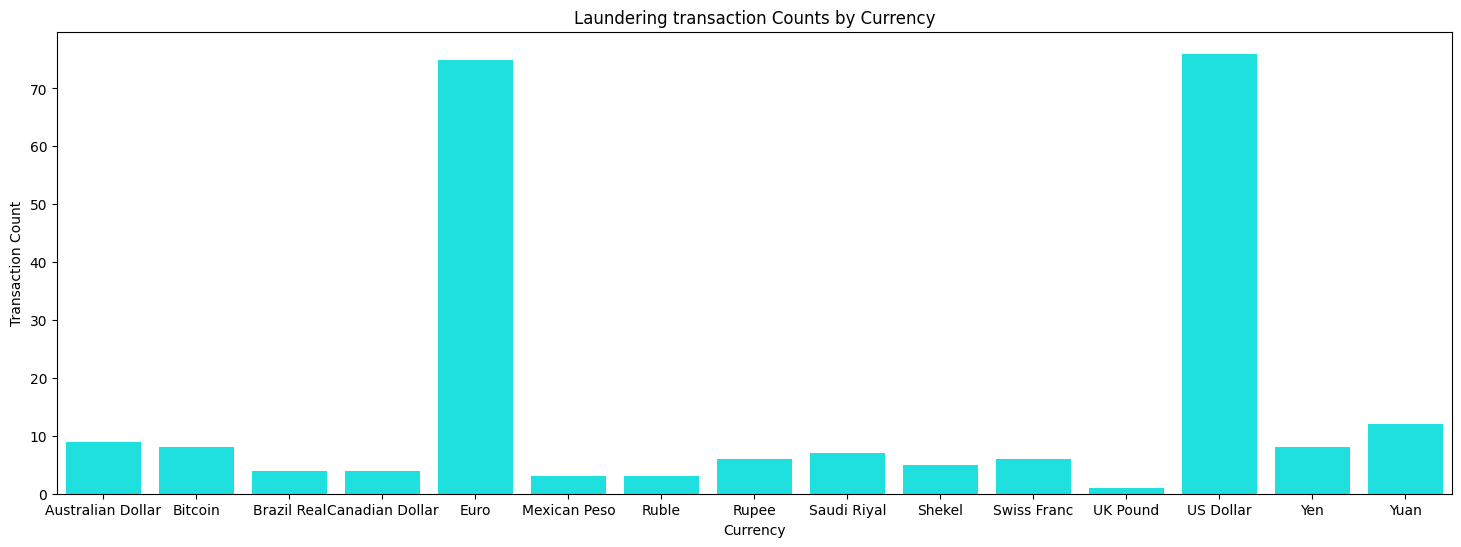

In [ ]:
import seaborn as sns
plt.figure(figsize=(18, 6))
custom_palette = sns.color_palette("husl", len(same_currencyL['Payment Currency'].unique()))

sns.barplot(x='Payment Currency', y='Transaction Count', data=same_currencyL,color="cyan")
plt.title('Laundering transaction Counts by Currency')
plt.xlabel('Currency')
plt.ylabel('Transaction Count')
plt.show()


In [ ]:
df=data
import sklearn.preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

In [ ]:
print(df.columns)


Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'To Account',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')


In [ ]:
def df_label_encoder(df, columns):
        le = preprocessing.LabelEncoder()
        for i in columns:
            df[i] = le.fit_transform(df[i].astype(str))
        return df

def preprocess(df):
    df = df_label_encoder(df,['Payment Format', 'Payment Currency', 'Receiving Currency'])
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Timestamp'] = df['Timestamp'].apply(lambda x: x.value)
    df['Timestamp'] = (df['Timestamp']-df['Timestamp'].min())/(df['Timestamp'].max()-df['Timestamp'].min())

    df['Account'] = df['From Bank'].astype(str) + '_' + df['Account']
    df['To Account'] = df['To Bank'].astype(str) + '_' + df['To Account']
    df = df.sort_values(by=['Account'])
    receiving_df = df[['To Account', 'Amount Received', 'Receiving Currency']]
    paying_df = df[['Account', 'Amount Paid', 'Payment Currency']]
    receiving_df = receiving_df.rename({'To Account': 'Account'}, axis=1)
    currency_ls = sorted(df['Receiving Currency'].unique())

    return df, receiving_df, paying_df, currency_ls





In [ ]:
df, receiving_df, paying_df, currency_ls = preprocess(df = df)
print(df.head())

         Timestamp  From Bank     Account  To Bank       To Account  \
166357    0.000114          0  0_8.00E+06        0       0_8.00E+06   
593900    0.001012          0  0_8.00E+06       14     14_8002A1780   
167471    0.000060          0  0_8.00E+06        0       0_8.00E+06   
1011429   0.003483          0  0_8.00E+06    11314  11314_81BD0EC40   
1011428   0.003460          0  0_8.00E+06    11314  11314_81BD0EC40   

         Amount Received  Receiving Currency  Amount Paid  Payment Currency  \
166357           3176.14                   4      3176.14                 4   
593900            304.71                   4       304.71                 4   
167471             74.68                   4        74.68                 4   
1011429            10.99                   4        10.99                 4   
1011428           165.59                   4       165.59                 4   

         Payment Format  Is Laundering  
166357                5              0  
593900          

In [ ]:
def get_all_account(df):
        ldf = df[['Account', 'From Bank']]
        rdf = df[['To Account', 'To Bank']]
        suspicious = df[df['Is Laundering']==1]
        s1 = suspicious[['Account', 'Is Laundering']]
        s2 = suspicious[['To Account', 'Is Laundering']]
        s2 = s2.rename({'To Account': 'Account'}, axis=1)
        suspicious = pd.concat([s1, s2], join='outer')
        suspicious = suspicious.drop_duplicates()

        ldf = ldf.rename({'From Bank': 'Bank'}, axis=1)
        rdf = rdf.rename({'To Account': 'Account', 'To Bank': 'Bank'}, axis=1)
        df = pd.concat([ldf, rdf], join='outer')
        df = df.drop_duplicates()

        df['Is Laundering'] = 0
        df.set_index('Account', inplace=True)
        df.update(suspicious.set_index('Account'))
        df = df.reset_index()
        return df
accounts = get_all_account(df)

In [ ]:
def paid_currency_aggregate(currency_ls, paying_df, accounts):
        for i in currency_ls:
            temp = paying_df[paying_df['Payment Currency'] == i]
            accounts['avg paid '+str(i)] = temp['Amount Paid'].groupby(temp['Account']).transform('mean')
        return accounts

def received_currency_aggregate(currency_ls, receiving_df, accounts):
    for i in currency_ls:
        temp = receiving_df[receiving_df['Receiving Currency'] == i]
        accounts['avg received '+str(i)] = temp['Amount Received'].groupby(temp['Account']).transform('mean')
    accounts = accounts.fillna(0)
    return accounts
def get_node_attr(currency_ls, paying_df,receiving_df, accounts):
        node_df = paid_currency_aggregate(currency_ls, paying_df, accounts)
        node_df = received_currency_aggregate(currency_ls, receiving_df, node_df)
        node_label = torch.from_numpy(node_df['Is Laundering'].values).to(torch.float)
        node_df = node_df.drop(['Account', 'Is Laundering'], axis=1)
        node_df = df_label_encoder(node_df,['Bank'])
#         node_df = torch.from_numpy(node_df.values).to(torch.float)  # comment for visualization
        return node_df, node_label
node_df, node_label = get_node_attr(currency_ls, paying_df,receiving_df, accounts)
print(node_df.head())

   Bank  avg paid 0  avg paid 1  avg paid 2  avg paid 3  avg paid 4  \
0     0         0.0         0.0         0.0         0.0         0.0   
1     0         0.0         0.0         0.0         0.0         0.0   
2     0         0.0         0.0         0.0         0.0         0.0   
3     0         0.0         0.0         0.0         0.0         0.0   
4     0         0.0         0.0         0.0         0.0         0.0   

   avg paid 5  avg paid 6  avg paid 7  avg paid 8  ...  avg received 5  \
0         0.0         0.0         0.0         0.0  ...             0.0   
1         0.0         0.0         0.0         0.0  ...             0.0   
2         0.0         0.0         0.0         0.0  ...             0.0   
3         0.0         0.0         0.0         0.0  ...             0.0   
4         0.0         0.0         0.0         0.0  ...             0.0   

   avg received 6  avg received 7  avg received 8  avg received 9  \
0             0.0             0.0             0.0          

In [ ]:
def get_edge_df(accounts, df):
        accounts = accounts.reset_index(drop=True)
        accounts['ID'] = accounts.index
        mapping_dict = dict(zip(accounts['Account'], accounts['ID']))
        df['From'] = df['Account'].map(mapping_dict)
        df['To'] = df['To Account'].map(mapping_dict)
        df = df.drop(['Account', 'To Account', 'From Bank', 'To Bank'], axis=1)

        edge_index = torch.stack([torch.from_numpy(df['From'].values), torch.from_numpy(df['To'].values)], dim=0)

        df = df.drop(['Is Laundering', 'From', 'To'], axis=1)

        edge_attr = df  # for visualization
        return edge_attr, edge_index
edge_attr, edge_index = get_edge_df(accounts, df)
print(edge_attr.head())

         Timestamp  Amount Received  Receiving Currency  Amount Paid  \
166357    0.000114          3176.14                   4      3176.14   
593900    0.001012           304.71                   4       304.71   
167471    0.000060            74.68                   4        74.68   
1011429   0.003483            10.99                   4        10.99   
1011428   0.003460           165.59                   4       165.59   

         Payment Currency  Payment Format  
166357                  4               5  
593900                  4               3  
167471                  4               5  
1011429                 4               0  
1011428                 4               3  


In [ ]:
print(edge_index)

tensor([[     0,      0,      0,  ..., 494156, 494156, 494157],
        [     0, 119081,      0,  ..., 494156, 494156, 494157]])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GATConv, Linear

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * heads, int(hidden_channels/4), heads=1, concat=False, dropout=0.6)
        self.lin = Linear(int(hidden_channels/4), out_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, edge_index, edge_attr):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.lin(x)
        x = self.sigmoid(x)

        return x

In [ ]:
from torch_geometric.data import InMemoryDataset
from typing import Callable, Optional

In [ ]:
class AMLtoGraph(InMemoryDataset):

    def __init__(self, root: str, edge_window_size: int = 10,
                 transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        self.edge_window_size = edge_window_size
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self) -> str:
        return 'LI-Small_Trans.csv'

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    @property
    def num_nodes(self) -> int:
        return self._data.edge_index.max().item() + 1

    def df_label_encoder(self, df, columns):
        le = preprocessing.LabelEncoder()
        for i in columns:
            df[i] = le.fit_transform(df[i].astype(str))
        return df


    def preprocess(self, df):
        df = self.df_label_encoder(df,['Payment Format', 'Payment Currency', 'Receiving Currency'])
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['Timestamp'] = df['Timestamp'].apply(lambda x: x.value)
        df['Timestamp'] = (df['Timestamp']-df['Timestamp'].min())/(df['Timestamp'].max()-df['Timestamp'].min())

        df['Account'] = df['From Bank'].astype(str) + '_' + df['Account']
        df['To Account'] = df['To Bank'].astype(str) + '_' + df['To Account']
        df = df.sort_values(by=['Account'])
        receiving_df = df[['To Account', 'Amount Received', 'Receiving Currency']]
        paying_df = df[['Account', 'Amount Paid', 'Payment Currency']]
        receiving_df = receiving_df.rename({'To Account': 'Account'}, axis=1)
        currency_ls = sorted(df['Receiving Currency'].unique())

        return df, receiving_df, paying_df, currency_ls

    def get_all_account(self, df):
        ldf = df[['Account', 'From Bank']]
        rdf = df[['To Account', 'To Bank']]
        suspicious = df[df['Is Laundering']==1]
        s1 = suspicious[['Account', 'Is Laundering']]
        s2 = suspicious[['To Account', 'Is Laundering']]
        s2 = s2.rename({'To Account': 'Account'}, axis=1)
        suspicious = pd.concat([s1, s2], join='outer')
        suspicious = suspicious.drop_duplicates()

        ldf = ldf.rename({'From Bank': 'Bank'}, axis=1)
        rdf = rdf.rename({'To Account': 'Account', 'To Bank': 'Bank'}, axis=1)
        df = pd.concat([ldf, rdf], join='outer')
        df = df.drop_duplicates()

        df['Is Laundering'] = 0
        df.set_index('Account', inplace=True)
        df.update(suspicious.set_index('Account'))
        df = df.reset_index()
        return df

    def paid_currency_aggregate(self, currency_ls, paying_df, accounts):
        for i in currency_ls:
            temp = paying_df[paying_df['Payment Currency'] == i]
            accounts['avg paid '+str(i)] = temp['Amount Paid'].groupby(temp['Account']).transform('mean')
        return accounts

    def received_currency_aggregate(self, currency_ls, receiving_df, accounts):
        for i in currency_ls:
            temp = receiving_df[receiving_df['Receiving Currency'] == i]
            accounts['avg received '+str(i)] = temp['Amount Received'].groupby(temp['Account']).transform('mean')
        accounts = accounts.fillna(0)
        return accounts

    def get_edge_df(self, accounts, df):
        accounts = accounts.reset_index(drop=True)
        accounts['ID'] = accounts.index
        mapping_dict = dict(zip(accounts['Account'], accounts['ID']))
        df['From'] = df['Account'].map(mapping_dict)
        df['To'] = df['To Account'].map(mapping_dict)
        df = df.drop(['Account', 'To Account', 'From Bank', 'To Bank'], axis=1)

        edge_index = torch.stack([torch.from_numpy(df['From'].values), torch.from_numpy(df['To'].values)], dim=0)

        df = df.drop(['Is Laundering', 'From', 'To'], axis=1)

        edge_attr = torch.from_numpy(df.values).to(torch.float)
        return edge_attr, edge_index

    def get_node_attr(self, currency_ls, paying_df,receiving_df, accounts):
        node_df = self.paid_currency_aggregate(currency_ls, paying_df, accounts)
        node_df = self.received_currency_aggregate(currency_ls, receiving_df, node_df)
        node_label = torch.from_numpy(node_df['Is Laundering'].values).to(torch.float)
        node_df = node_df.drop(['Account', 'Is Laundering'], axis=1)
        node_df = self.df_label_encoder(node_df,['Bank'])
        node_df = torch.from_numpy(node_df.values).to(torch.float)
        return node_df, node_label

    def process(self):
        df = pd.read_csv(self.raw_paths[0])
        df, receiving_df, paying_df, currency_ls = self.preprocess(df)
        accounts = self.get_all_account(df)
        node_attr, node_label = self.get_node_attr(currency_ls, paying_df,receiving_df, accounts)
        edge_attr, edge_index = self.get_edge_df(accounts, df)

        data = Data(x=node_attr,
                    edge_index=edge_index,
                    y=node_label,
                    edge_attr=edge_attr
                    )

        data_list = [data]
        if self.pre_filter is not None:
            data_list = [d for d in data_list if self.pre_filter(d)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(d) for d in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [ ]:
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.loader import NeighborLoader


In [ ]:
dataset = AMLtoGraph('/content/drive/MyDrive/MLGA')
data = dataset[0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GAT(in_channels=data.num_features, hidden_channels=16, out_channels=1, heads=8)
model = model.to(device)


criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

# Split the data
split = RandomNodeSplit(split='train_rest', num_val=0.1, num_test=0)
data = split(data)

# Define the data loaders
train_loader = NeighborLoader(data, num_neighbors=[30] * 2, batch_size=256, input_nodes=data.train_mask)
test_loader = NeighborLoader(data, num_neighbors=[30] * 2, batch_size=256, input_nodes=data.val_mask)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        data.to(device)
        pred = model(data.x, data.edge_index, data.edge_attr)
        ground_truth = data.y
        loss = criterion(pred, ground_truth.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += float(loss)
    if epoch % 2 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {total_loss:.4f}")
        model.eval()
        acc = 0
        total = 0
        with torch.no_grad():
            for test_data in test_loader:
                test_data.to(device)
                pred = model(test_data.x, test_data.edge_index, test_data.edge_attr)
                ground_truth = test_data.y
                correct = (pred == ground_truth.unsqueeze(1)).sum().item()
                total += len(ground_truth)
                acc += correct
            acc = acc / total
            print('accuracy:', acc)

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


Epoch: 000, Loss: 5779.5209
accuracy: 0.8704775687409552
Epoch: 002, Loss: 1285.4553
accuracy: 0.8933152786248101
Epoch: 004, Loss: 1201.1196
accuracy: 0.9203121769691958
Epoch: 006, Loss: 1100.2876
accuracy: 0.9369540722976256
Epoch: 008, Loss: 1009.8367
accuracy: 0.9458439719244566
